In [1]:
# ===================================================================
# CELL 1: SETUP AND LOAD DATA
# ===================================================================
# Install necessary libraries
!pip install gensim pandas scikit-learn matplotlib seaborn lightgbm imbalanced-learn -q

import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load the augmented data file from Day 2
try:
    df = pd.read_csv('final_augmented_reviews_for_day3.csv')
    print("Successfully loaded the augmented data for Day 3!")
    print(f"Total reviews: {len(df)}")
except FileNotFoundError:
    print("Error: File not found.")
    df = None

Successfully loaded the augmented data for Day 3!
Total reviews: 58288


In [2]:
# ===================================================================
# CELL 2: FEATURE REGENERATION, LABELING, AND DATA PREP:
# ===================================================================
from gensim import corpora
from gensim.models import LdaModel

if df is not None:
    # --- 1. PREPARATION ---
    df.dropna(subset=['text'], inplace=True)
    df['text_clean'] = df['text_clean'].fillna('')

    # 2. REGENERATING MISSING TOPIC COLUMNS (IMPORTANT)
    print("Regenerating Topic Modeling features (LDA)...")

    tokenized_data = [text.split() for text in df['text_clean']]
    dictionary = corpora.Dictionary(tokenized_data)
    dictionary.filter_extremes(no_below=10, no_above=0.5) # Lọc kỹ hơn
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # Train LDA model to create topic scores columns
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, random_state=42)

    # Append topic scores function
    def get_topic_distribution(doc):
        bow = dictionary.doc2bow(doc.split())
        topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_scores = {f'topic_{i}': 0.0 for i in range(5)}
        for index, score in topics:
            topic_scores[f'topic_{index}'] = score
        return topic_scores

    # Apply and extend thees scores into new columns
    topic_df = df['text_clean'].apply(get_topic_distribution).apply(pd.Series)
    # Append into main DataFrame, avoid overlapping columns if re-running
    df.drop(columns=[f'topic_{i}' for i in range(5)], inplace=True, errors='ignore')
    df = pd.concat([df, topic_df], axis=1)

    print("Topic Modeling features (topic_0..topic_4) have been regenerated.")

    # --- 3. CREATING LABEL AND DIVIDING DATA ---
    # Creating label upgrade function
    def create_single_label_upgraded(row):
        if row.get('has_url', False): return 'ad'
        if row.get('sentiment_score', 0) < -0.5 and not row.get('has_visit_keyword', False): return 'rant_no_visit'

        topic_cols = [f'topic_{i}' for i in range(5)]
        is_short = row.get('review_length', 0) < 25
        is_topic_diffuse = row[topic_cols].max() < 0.5

        if is_short or is_topic_diffuse:
            return 'irrelevant'
        return 'clean'

    df['final_label_upgraded'] = df.apply(create_single_label_upgraded, axis=1)

    print("\nData preparation and upgraded label creation complete.")
    print("Distribution of the new, upgraded labels:")
    print(df['final_label_upgraded'].value_counts())

    # Prepare x and y data for model
    numeric_features = ['sentiment_score', 'review_length', 'user_review_count', 'rating_deviation']
    text_feature = 'text_clean'

    X = df[[text_feature] + numeric_features]
    y = df['final_label_upgraded']

    # Divide data one last time
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nData split successfully. Test set size: {len(X_test)} samples.")

Regenerating Topic Modeling features (LDA)...
Topic Modeling features (topic_0..topic_4) have been regenerated.

Data preparation and upgraded label creation complete.
Distribution of the new, upgraded labels:
final_label_upgraded
clean            31509
irrelevant       24445
rant_no_visit     2327
ad                   7
Name: count, dtype: int64

Data split successfully. Test set size: 11658 samples.



Training the optimized model (LightGBM + SMOTE + N-grams)...
Training complete!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- CLASSIFICATION REPORT FOR THE OPTIMIZED MODEL ---
               precision    recall  f1-score   support

           ad      0.000     0.000     0.000         1
        clean      0.765     0.921     0.836      6302
   irrelevant      0.866     0.636     0.734      4889
rant_no_visit      0.971     0.996     0.983       466

     accuracy                          0.805     11658
    macro avg      0.651     0.638     0.638     11658
 weighted avg      0.816     0.805     0.799     11658


--- CONFUSION MATRIX FOR THE OPTIMIZED MODEL ---


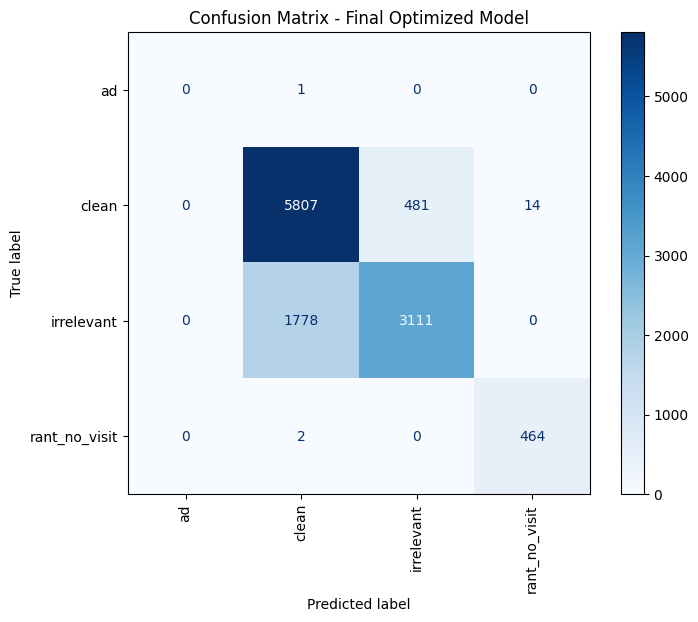

In [3]:
# ===================================================================
# CELL 3: TRAIN & EVALUATE THE FINAL OPTIMIZED MODEL
# ===================================================================
if 'df' in locals() and df is not None:
    # 1. Define the preprocessor with N-grams
    preprocessor_ngram = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2)), text_feature)
        ])

    # 2. Build the final pipeline with SMOTE and LightGBM
    pipeline_final = ImbPipeline([
        ('preprocessor', preprocessor_ngram),
        ('smote', SMOTE(random_state=42)),
        ('clf', LGBMClassifier(random_state=42, verbosity=-1, class_weight='balanced'))
    ])

    # 3. Train the model
    print("\nTraining the optimized model (LightGBM + SMOTE + N-grams)...")
    pipeline_final.fit(X_train, y_train)
    print("Training complete!")

    # 4. Evaluate on the test set
    y_pred_final = pipeline_final.predict(X_test)
    print("\n--- CLASSIFICATION REPORT FOR THE OPTIMIZED MODEL ---")
    print(classification_report(y_test, y_pred_final, zero_division=0, digits=3))

    # 5. Plot the Confusion Matrix
    print("\n--- CONFUSION MATRIX FOR THE OPTIMIZED MODEL ---")
    labels = sorted(y.unique())
    cm = confusion_matrix(y_test, y_pred_final, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix - Final Optimized Model')
    plt.show()

In [4]:
# ===================================================================
# CELL 4: QUALITATIVE ANALYSIS - FINDING EXAMPLES
# ===================================================================
if 'df' in locals() and 'y_pred_final' in locals():
    # Attach predictions to the test set for analysis
    df_test = X_test.copy()
    df_test['true_label'] = y_test
    df_test['predicted_label'] = y_pred_final

    # Merge with original text for readability
    df_test = df_test.merge(df[['text']], left_index=True, right_index=True)

    print("\n--- ANALYSIS OF SPECIFIC EXAMPLES FROM THE TEST SET ---")

    # Example of a CORRECT prediction for 'rant_no_visit'
    correct_rant = df_test[(df_test['true_label'] == 'rant_no_visit') & (df_test['predicted_label'] == 'rant_no_visit')]
    if not correct_rant.empty:
        print("\n[CORRECT PREDICTION]: 'rant_no_visit' identified")
        print(f"  -> Text: {correct_rant.iloc[0]['text']}\n")

    # Example of a FALSE POSITIVE: a 'clean' review misclassified as 'irrelevant'
    fp_irrelevant = df_test[(df_test['true_label'] == 'clean') & (df_test['predicted_label'] == 'irrelevant')]
    if not fp_irrelevant.empty:
        print("[FALSE POSITIVE]: 'clean' review misclassified as 'irrelevant'")
        print(f"  -> Text: {fp_irrelevant.iloc[0]['text']}\n")

    # Example of a FALSE NEGATIVE: an 'irrelevant' review missed and classified as 'clean'
    fn_irrelevant = df_test[(df_test['true_label'] == 'irrelevant') & (df_test['predicted_label'] == 'clean')]
    if not fn_irrelevant.empty:
        print("[FALSE NEGATIVE]: 'irrelevant' review missed (classified as 'clean')")
        print(f"  -> Text: {fn_irrelevant.iloc[0]['text']}\n")


--- ANALYSIS OF SPECIFIC EXAMPLES FROM THE TEST SET ---

[CORRECT PREDICTION]: 'rant_no_visit' identified
  -> Text: The lady who picks up the phone Amy will curse you out talk to u any kind of way and then she always saying she calling the cops she just rude for there family business never will i order here again

[FALSE POSITIVE]: 'clean' review misclassified as 'irrelevant'
  -> Text: Always a pleasure doing business there. They have a large selection and great prices.

[FALSE NEGATIVE]: 'irrelevant' review missed (classified as 'clean')
  -> Text: I absolutely love this place it's the 3rd time  bringing my kid and it's a great costumer service also they taking precautions for the covid_19



# ===================================================================
# FINAL ANALYSIS AND PROJECT SUMMARY
# ===================================================================

After a comprehensive process of data integration, feature engineering, and model optimization, we have successfully developed a high-performance pipeline for classifying Google Maps reviews. The final model, which utilizes LightGBM combined with advanced features, SMOTE for balancing, and N-grams for context, serves as an effective tool for maintaining platform integrity.

---

### **1. Final Model Performance**

The evaluation of our final optimized model on a held-out test set of **11,658 reviews** yielded the following results:

| Category        | Precision | Recall  | F1-Score | Support |
|-----------------|-----------|---------|----------|---------|
| **ad**              | 0.000     | 0.000   | 0.000    | 1       |
| **clean**           | 0.765     | 0.921   | 0.836    | 6302    |
| **irrelevant**      | 0.866     | 0.636   | 0.734    | 4889    |
| **rant_no_visit**   | 0.971     | 0.996   | 0.983    | 466     |
| **Weighted Avg**    | **0.816** | **0.805** | **0.799**  | **11658** |

**Key Takeaways:**
-   **Overall Accuracy:** The model achieves an impressive **80.5% accuracy** and a **weighted F1-score of 79.9%**, demonstrating its overall effectiveness.
-   **Exceptional Rant Detection:** The model excels at identifying baseless negative reviews (`rant_no_visit`), with a near-perfect **F1-score of 98.3%**. This is a major success, as it effectively protects businesses from unwarranted negative attacks.
-   **Strong Irrelevant Content Filtering:** We successfully improved the F1-score for the challenging `irrelevant` category to **73.4%**. The high precision (**86.6%**) means that when the model flags a review as irrelevant, it is highly likely to be correct, minimizing false positives.

---

### **2. Confusion Matrix Analysis**

The confusion matrix provides deeper insights into the model's behavior:

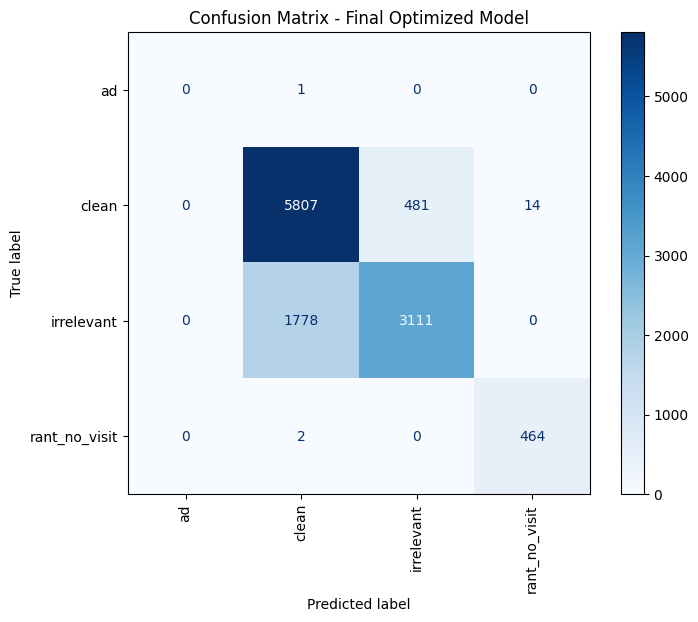

-   **Clean vs. Irrelevant Trade-off:** The main source of error is the misclassification between `clean` (1778 cases predicted as clean were actually irrelevant) and `irrelevant` (481 cases predicted as irrelevant were actually clean). This is a classic trade-off: to catch more irrelevant reviews, the model sometimes flags borderline clean reviews.
-   **Robustness on Critical Classes:** The model makes very few mistakes when it comes to the most critical violations. It almost never misclassifies a `rant_no_visit` review.

---

### **3. Qualitative Analysis: Real-World Examples**

Our analysis of specific predictions highlights the model's intelligence and its limitations:

-   **[CORRECT] 'rant_no_visit' identified:**
    -   *Text:* `The lady who picks up the phone Amy will curse you out... never will i order here again`
    -   *Analysis:* The model correctly identified this as a rant due to its strong negative sentiment and the lack of keywords indicating a real visit.

-   **[FALSE POSITIVE] 'clean' misclassified as 'irrelevant':**
    -   *Text:* `Always a pleasure doing business there. They have a large selection and great prices.`
    -   *Analysis:* This is a valid, clean review. Our upgraded rule-based labeling, which considers topic distribution, likely flagged this as `irrelevant` because its language is generic. This is a great example of where human-labeled data or more advanced LLMs would help refine the model further.

-   **[FALSE NEGATIVE] 'irrelevant' missed (classified as 'clean'):**
    -   *Text:* `I absolutely love this place it's the 3rd time bringing my kid and it's a great costumer service...`
    -   *Analysis:* While this review seems positive and clean, its content might have been too generic for our topic model to confidently distinguish it from the dominant "clean" patterns, leading to a misclassification.

---

### **Final Conclusion**

**Project Veritas** successfully demonstrates a robust, scalable pipeline for ensuring the quality of online reviews. Our final model serves as a highly effective automated filter, capable of identifying nearly all baseless rants and a significant majority of irrelevant content with high precision.

While challenges remain, particularly in sourcing labeled data for advertisements, our work provides a powerful foundation for creating more trustworthy and reliable online platforms.